In [40]:
import json
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

In [41]:
# loading reaction rates
with open('reaction_rates.json') as f:
    kx = json.load(f)
f.close()
# loading degradation rates
with open('degradation_rates.json') as f:
    dr = json.load(f)
f.close()
# loading transcription rates
with open('transcription_rates.json') as f:
    tr = json.load(f)
f.close()
# loading hill coefficients of transcription
with open('hill_coefficients_of_transcription.json') as f:
    hcoeff = json.load(f)
f.close()
# loading 
with open('import_export_rates.json') as f:
    impexpr = json.load(f)
f.close()
# loading 
with open('activation_inhibition_rates.json') as f:
    air = json.load(f)
f.close()
# loading 
with open('production_rates.json') as f:
    pr = json.load(f)
f.close()
# loading 
with open('transcription_fold_activation_rates.json') as f:
    tfa = json.load(f)
f.close()
# loading 
with open('exogenous_rna.json') as f:
    yi_0 = json.load(f)
f.close()

In [42]:
def val(x): return x['value']

In [50]:
def circadian_rhythm(t, proteins):
    """
        TODO: copy paste the xi, yi, zi notation here
    """
    # unpacking the values of the proteins
    x1, x2, x3, x4, x5, x6, x7 = proteins[:7]
    y1, y2, y3, y4, y5 = proteins[7:12]
    z1, z2, z3, z4, z5, z6, z7, z8 = proteins[12:]
    
    # odes from the paper
    # clock odes
    dx1dt = val(kx['kf_x1']) * x7 - (val(kx['kd_x1']) + val(dr['dr_x1'])) * x1
    # ror and rev-erb odes
    dy3dthelper = (x1 / val(air['ar_y3']))**val(hcoeff['v'])
    dy3dt = val(tr['tr_y3']) * (1 + val(tfa['g']) * dy3dthelper) / (1 + dy3dthelper * (1 + (x4 / val(air['ir_y3']))**val(hcoeff['w']))) - val(dr['dr_y3']) * y3
    dy4dthelper = (x1 / val(air['ar_y4']))**val(hcoeff['p'])
    dy4dt = val(tr['tr_y4']) * (1 + val(tfa['h']) * dy4dthelper) / (1 + dy4dthelper * (1 + (x4 / val(air['ir_y4']))**val(hcoeff['q']))) - val(dr['dr_y4']) * y4
    dz6dt = val(pr['pr_y3']) * (y3 + val(yi_0['y3_0'])) - (val(impexpr['impr_z6']) + val(dr['dr_z6'])) * z6
    dz7dt = val(pr['pr_y4']) * (y4 + val(yi_0['y4_0'])) - (val(impexpr['impr_z7']) + val(dr['dr_z7'])) * z7
    dx5dt = val(impexpr['impr_z6']) * z6 - val(dr['dr_x5']) * x5
    dx6dt = val(impexpr['impr_z7']) * z7 - val(dr['dr_x6']) * x6
    # bmal odes
    dy5dthelper = (x6 / val(air['ar_y5']))**val(hcoeff['n'])
    dy5dt = val(tr['tr_y5']) * (1 + val(tfa['i']) * dy5dthelper) / (1 + dy5dthelper + (x5 / val(air['ir_y5']))**val(hcoeff['m'])) - val(dr['dr_y5']) * y5
    dz8dt = val(pr['pr_y5']) * (y5 + val(yi_0['y5_0'])) - (val(impexpr['impr_z8']) + val(dr['dr_z8'])) * z8
    dx7dt = val(impexpr['impr_z8']) * z8 + val(kx['kd_x1']) * x1 - (val(kx['kf_x1']) + val(dr['dr_x7'])) * x7
    # per and cry odes
    dy1dthelper = (x1 / val(air['ar_y1']))**val(hcoeff['b'])
    dy1dt = val(tr['tr_y1']) * (1 + val(tfa['a']) * dy1dthelper) / (1 + dy1dthelper * (1 + (x4 / val(air['ir_y1']))**val(hcoeff['c']))) - val(dr['dr_y1']) * y1
    dy2dthelper = (x1 / val(air['ar_y2']))**val(hcoeff['e'])
    dy2dt = val(tr['tr_y2']) * (1 + val(tfa['d']) * dy2dthelper) / (1 + dy2dthelper * (1 + (x4 / val(air['ir_y2']))**val(hcoeff['f']))) * 1 / (1 + (x5 / val(air['ir_y21']))**val(hcoeff['f1'])) - val(dr['dr_y2']) * y2
    dz1dt = val(pr['pr_y2']) * (y2 + val(yi_0['y2_0'])) + val(kx['kd_z4']) * z4 - val(kx['kf_z4']) * z1 * z3 + val(kx['kd_z5']) * z5 - val(kx['kf_z5']) * z1 * z2 - val(dr['dr_z1']) * z1
    dz2dt = val(pr['pr_y1']) * (y1 + val(yi_0['y1_0'])) + val(kx['kdph_z3']) * z3 - val(kx['kph_z2']) * z2 + val(kx['kd_z5']) * z5 - val(kx['kf_z5']) * z1 * z2 - val(dr['dr_z2']) * z2
    dz3dt = val(kx['kph_z2']) * z2 - val(kx['kdph_z3']) * z3 + val(kx['kd_z4']) * z4 - val(kx['kf_z4']) * z1 * z3 - val(dr['dr_z3']) * z3
    dz4dt = val(kx['kf_z4']) * z1 * z3 - val(kx['kd_z4']) * z4 + val(impexpr['expr_x2']) * x2 - val(impexpr['impr_z4']) * z4 - val(dr['dr_z4']) * z4
    dz5dt = val(kx['kf_z5']) * z1 * z2 - val(kx['kd_z5']) * z5 + val(impexpr['expr_x3']) * x3 - val(impexpr['impr_z5']) * z5 - val(dr['dr_z5']) * z5
    dx2dt = val(impexpr['impr_z4']) * z4 - val(impexpr['expr_x2']) * x2 - val(dr['dr_x2']) * x2
    dx3dt = val(impexpr['impr_z5']) * z5 - val(impexpr['expr_x3']) * x3 - val(dr['dr_x3']) * x3
    dx4dt = dx2dt + dx3dt
    odes = [dx1dt, dx2dt, dx3dt, dx4dt, dx5dt, dx6dt, dx7dt, dy1dt, dy2dt, dy3dt, dy4dt, dy5dt, dz1dt, dz2dt, dz3dt, dz4dt, dz5dt, dz6dt, dz7dt, dz8dt]
    return odes

In [67]:
# dummy initial values
init = np.random.rand(20)
# init = np.zeros(20)
t_start = 0
t_end = 72
dt = 0.0001
t_eval = np.linspace(t_start, t_end, int((t_end - t_start)/dt) + 1)

In [68]:
soln = solve_ivp(
    fun = lambda t, c: circadian_rhythm(t, c),
    t_span = [t_start, t_end],
    y0 = init,
    t_eval = t_eval,
    method = 'RK45'
)

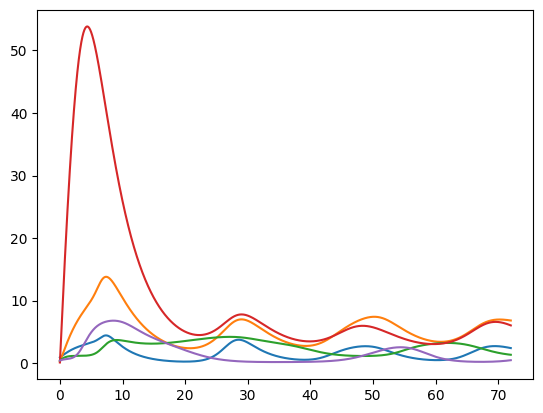

In [69]:
for i in range(7, 12):
    plt.plot(soln.t, soln.y[i])